# Import libraries and modeling data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle as pkl
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import BernoulliNB
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, plot_confusion_matrix
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from imblearn.over_sampling import SMOTE, ADASYN
import json
import sys
import requests
import warnings
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

In [2]:
with open('../data/modeling_data.pkl', 'rb') as f:
    df = pkl.load(f)

# Testing several model types

## Set features

In [3]:
features = ['rush_hour', 'weekend', 'mon', 'tue', 'wed', 'th', 'fri', 'bronx', 'brooklyn',
            'manhattan', 'queens','direction_bronx', 'direction_brooklyn', 'causes_station',
            'causes_train', 'causes_weather', 'causes_passenger', 'causes_other','direction_manhattan',
            'direction_queens', 'direction_unspecified', 'fastest_wind_spd','avg_wind_spd', 'major_conditions',
            'minor_conditions', 'neutral_conditions', 'clear_conditions', 'max_temp', 'avg_temp', 'min_temp',
            'prcp', 'snowfall', 'snowfall_depth']

## Bernoulli Naive Bayes

In [4]:
X = df[features]
y = df['delayed_irt']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)

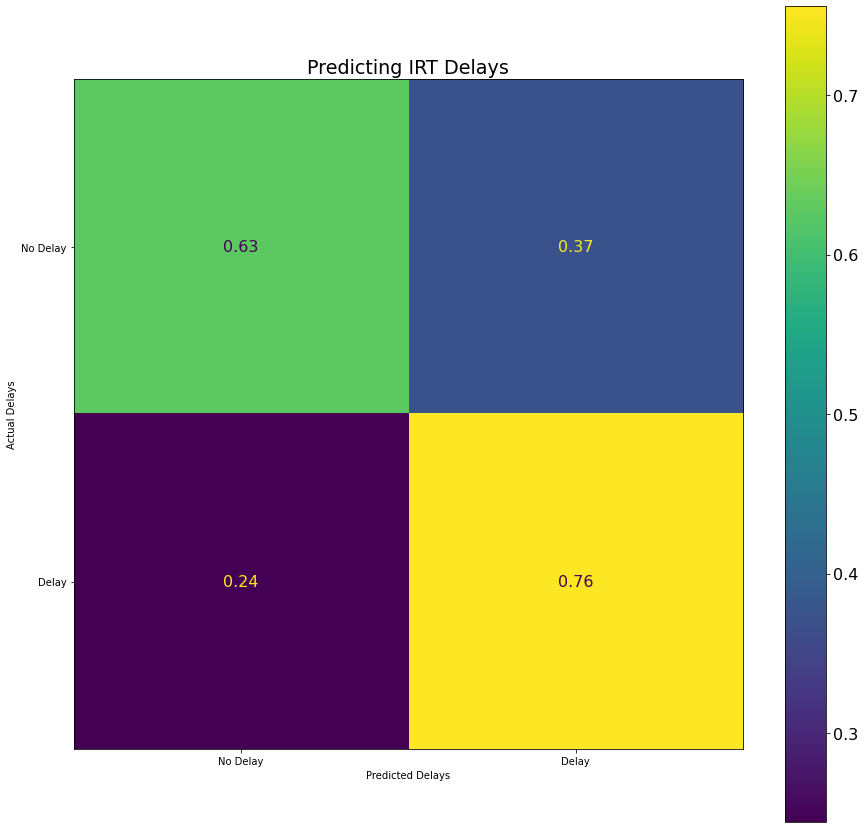

Pipeline(steps=[('bnb', BernoulliNB(alpha=0))])

Overall Accuracy: 69.05%,
F1 Score: 59.56%

Overall SMOTE Accuracy: 67.82000000000001%,
SMOTE F1 Score: 65.07%


In [5]:
bnb_params = {'bnb__alpha':[1,.9,.5,.2,0]}
pipe_bnb = Pipeline(steps=[('bnb',BernoulliNB())])

gsv_bnb = GridSearchCV(pipe_bnb, bnb_params,scoring='f1')
gsv_bnb_sm = GridSearchCV(pipe_bnb, bnb_params,scoring='f1')

gsv_bnb.fit(X_train, y_train)
gsv_bnb_sm.fit(X_train_resampled, y_train_resampled)

y_pred = gsv_bnb.best_estimator_.predict(X_test)
y_pred_sm = gsv_bnb_sm.best_estimator_.predict(X_test)

fig, ax = plt.subplots(figsize=(15, 15))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(gsv_bnb_sm, X_test, y_test, normalize='true', ax=ax, display_labels=['No Delay','Delay'])
ax.set_xlabel('Predicted Delays')
ax.set_ylabel('Actual Delays')
ax.set_title('Predicting IRT Delays')
plt.show()

# checking the best estimators from gsv
print(gsv_bnb_sm.best_estimator_)

print(f"""
Overall Accuracy: {(round(accuracy_score(y_test, y_pred), 4)*100)}%,
F1 Score: {(round(f1_score(y_test,y_pred),4)*100)}%

Overall SMOTE Accuracy: {(round(accuracy_score(y_test, y_pred_sm), 4)*100)}%,
SMOTE F1 Score: {(round(f1_score(y_test,y_pred_sm),4)*100)}%""")

## Decision Tree Classifier

In [6]:
X = df[features]
y = df['delayed_irt']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)

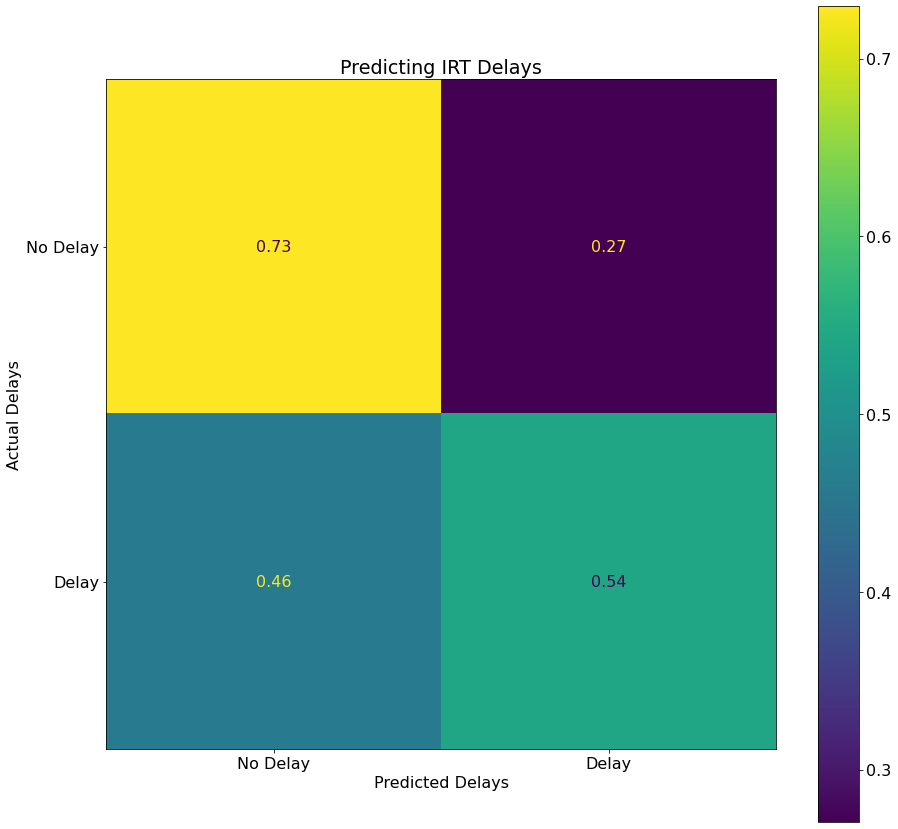

Pipeline(steps=[('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='entropy',
                                        max_features='auto', random_state=42,
                                        splitter='random'))])

Overall Accuracy: 64.62%,
F1 Score: 57.38999999999999%

Overall SMOTE Accuracy: 65.51%,
SMOTE F1 Score: 55.489999999999995%


In [7]:
dtc = DecisionTreeClassifier(random_state=42)

dtc_params = {'decisiontreeclassifier__criterion': ['gini','entropy'],
              'decisiontreeclassifier__splitter':['best','random'],
              'decisiontreeclassifier__max_features':['auto','sqrt','log2'],
              'decisiontreeclassifier__class_weight':['balanced',None, .25]
            }

pipe_dtc = make_pipeline(dtc)
pipe_dtc.fit(X_train,y_train)

gsv_dtc = GridSearchCV(pipe_dtc, dtc_params,scoring='f1')
gsv_dtc_sm = GridSearchCV(pipe_dtc, dtc_params,scoring='f1')

gsv_dtc.fit(X_train, y_train)
gsv_dtc_sm.fit(X_train_resampled, y_train_resampled)

y_pred = gsv_dtc.best_estimator_.predict(X_test)
y_pred_sm = gsv_dtc_sm.best_estimator_.predict(X_test)

fig, ax = plt.subplots(figsize=(15, 15))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(gsv_dtc_sm, X_test, y_test, normalize='true', ax=ax, display_labels=['No Delay','Delay'])
ax.set_xlabel('Predicted Delays')
ax.set_ylabel('Actual Delays')
ax.set_title('Predicting IRT Delays')
plt.show()

# checking the best estimators from gsv
print(gsv_dtc_sm.best_estimator_)

print(f"""
Overall Accuracy: {(round(accuracy_score(y_test, y_pred), 4)*100)}%,
F1 Score: {(round(f1_score(y_test,y_pred),4)*100)}%

Overall SMOTE Accuracy: {(round(accuracy_score(y_test, y_pred_sm), 4)*100)}%,
SMOTE F1 Score: {(round(f1_score(y_test,y_pred_sm),4)*100)}%""")

## Logistic Regression

In [8]:
X = df[features]
y = df['delayed_irt']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)

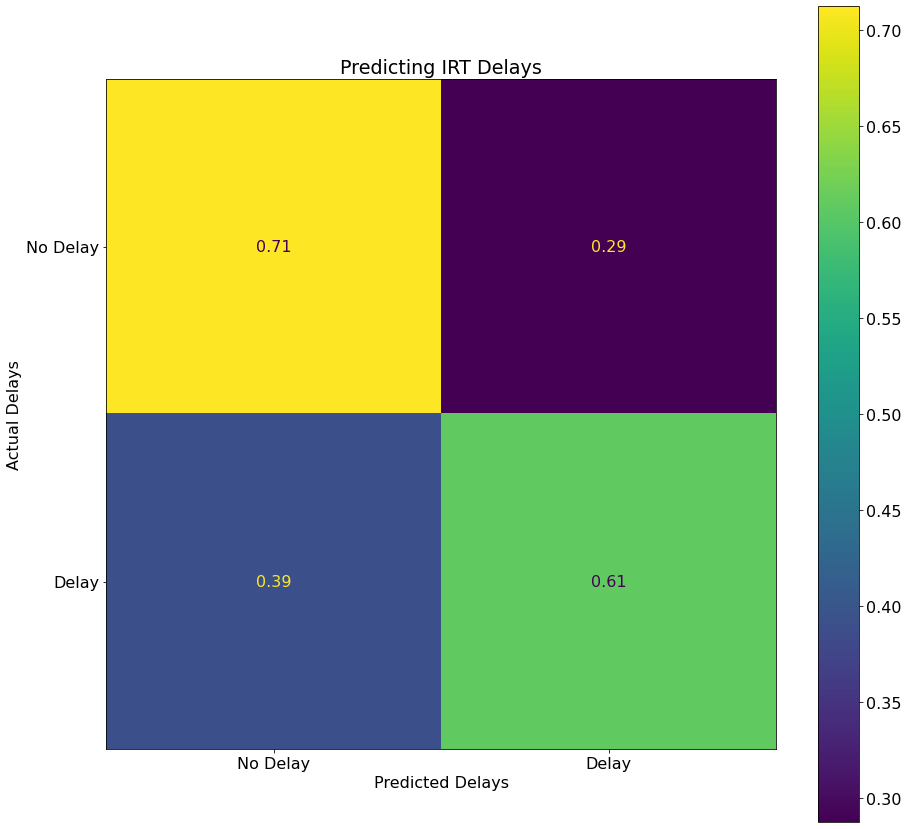

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.25, class_weight='balanced',
                                    random_state=42, solver='saga'))])

Overall Accuracy: 67.72%,
F1 Score: 65.63%

Overall SMOTE Accuracy: 67.14%,
SMOTE F1 Score: 59.53000000000001%


In [9]:
lr = LogisticRegression(random_state=42)
scaler = StandardScaler()

lr_params = {'logisticregression__C': [.25,.5,.75,1, 10, 100],
             'logisticregression__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
             'logisticregression__dual':[True,False],
             'logisticregression__fit_intercept':[True,False],
             'logisticregression__class_weight':['balanced',None, .25]
            }

pipe_lr = make_pipeline(scaler, lr)
pipe_lr.fit(X_train,y_train)

gsv_lr = GridSearchCV(pipe_lr, lr_params,scoring='f1')
gsv_lr_sm = GridSearchCV(pipe_lr, lr_params,scoring='f1')

gsv_lr.fit(X_train, y_train)
gsv_lr_sm.fit(X_train_resampled, y_train_resampled)

y_pred = gsv_lr.best_estimator_.predict(X_test)
y_pred_sm = gsv_lr_sm.best_estimator_.predict(X_test)

fig, ax = plt.subplots(figsize=(15, 15))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(gsv_lr_sm, X_test, y_test, normalize='true', ax=ax, display_labels=['No Delay','Delay'])
ax.set_xlabel('Predicted Delays')
ax.set_ylabel('Actual Delays')
ax.set_title('Predicting IRT Delays')
plt.show()

# checking the best estimators from gsv
print(gsv_lr_sm.best_estimator_)

print(f"""
Overall Accuracy: {(round(accuracy_score(y_test, y_pred), 4)*100)}%,
F1 Score: {(round(f1_score(y_test,y_pred),4)*100)}%

Overall SMOTE Accuracy: {(round(accuracy_score(y_test, y_pred_sm), 4)*100)}%,
SMOTE F1 Score: {(round(f1_score(y_test,y_pred_sm),4)*100)}%""")

## Random Forest

In [10]:
X = df[features]
y = df['delayed_irt']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)

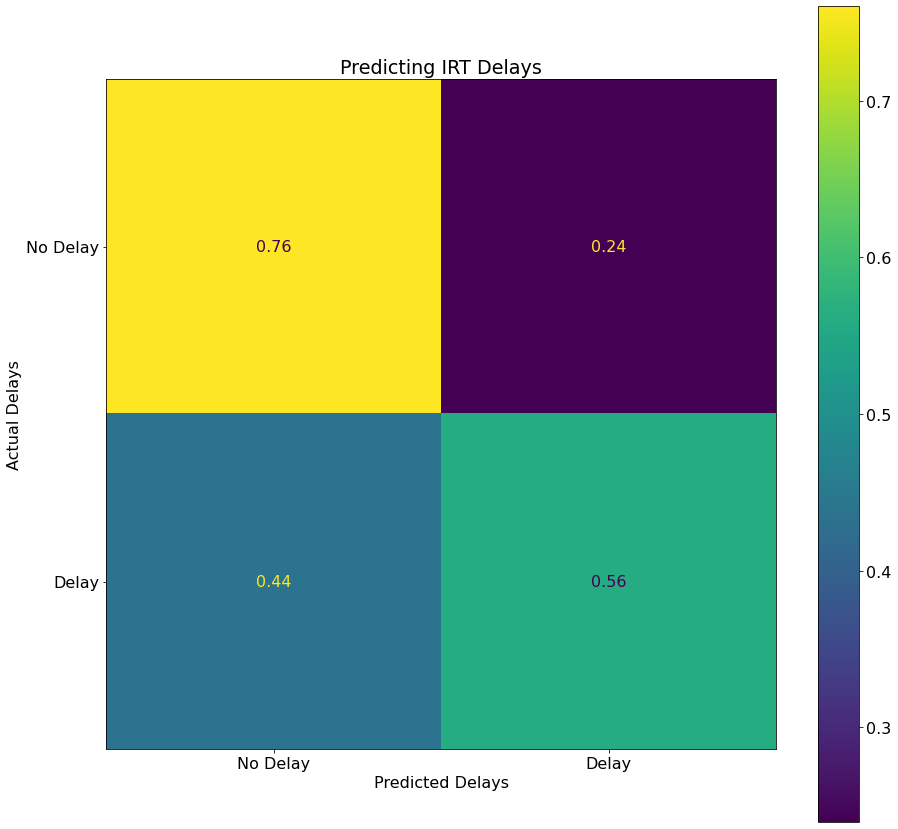

Pipeline(steps=[('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy',
                                        random_state=42))])

Overall Accuracy: 67.82000000000001%,
F1 Score: 58.98%

Overall SMOTE Accuracy: 68.2%,
SMOTE F1 Score: 58.41%


In [11]:
clf = RandomForestClassifier(random_state=42)

clf_params = {'clf__criterion':['gini','entropy'],
              'clf__max_features':['auto','sqrt','log2'],
              'clf__bootstrap':[True,False],
              'clf__class_weight':['balanced','balanced_subsample']}

pipe_clf = Pipeline(steps=[('clf',clf)])
pipe_clf.fit(X_train, y_train)

gsv_clf = GridSearchCV(pipe_clf, clf_params,scoring='f1')
gsv_clf_sm = GridSearchCV(pipe_clf, clf_params,scoring='f1')

gsv_clf.fit(X_train, y_train)
gsv_clf_sm.fit(X_train_resampled, y_train_resampled)

y_pred = gsv_clf.best_estimator_.predict(X_test)
y_pred_sm = gsv_clf_sm.best_estimator_.predict(X_test)

fig, ax = plt.subplots(figsize=(15, 15))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(gsv_clf_sm, X_test, y_test, normalize='true', ax=ax, display_labels=['No Delay','Delay'])
ax.set_xlabel('Predicted Delays')
ax.set_ylabel('Actual Delays')
ax.set_title('Predicting IRT Delays')
plt.show()

# checking the best estimators from gsv
print(gsv_clf_sm.best_estimator_)

print(f"""
Overall Accuracy: {(round(accuracy_score(y_test, y_pred), 4)*100)}%,
F1 Score: {(round(f1_score(y_test,y_pred),4)*100)}%

Overall SMOTE Accuracy: {(round(accuracy_score(y_test, y_pred_sm), 4)*100)}%,
SMOTE F1 Score: {(round(f1_score(y_test,y_pred_sm),4)*100)}%""")

# Best Models are LR and BNB

## LR with unsmoted data, BNB with smoted.

In [15]:
print(gsv_lr.best_estimator_)
print(gsv_bnb_sm.best_estimator_)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.5, class_weight='balanced', dual=True,
                                    fit_intercept=False, random_state=42,
                                    solver='liblinear'))])
Pipeline(steps=[('bnb', BernoulliNB(alpha=0))])


## Fitting LR Model

In [16]:
X = df[features]
y = df['delayed_irt']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [17]:
lr = Pipeline(steps=[('standardscaler', StandardScaler()),
                     ('logisticregression',
                      LogisticRegression(C=0.5, class_weight='balanced', dual=True,
                                         fit_intercept=False, random_state=42,solver='liblinear'))])
lr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.5, class_weight='balanced', dual=True,
                                    fit_intercept=False, random_state=42,
                                    solver='liblinear'))])

## Fitting BNB Model

In [18]:
X = df[features]
y = df['delayed_irt']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)

In [20]:
bnb = Pipeline(steps=[('bnb',BernoulliNB(alpha=0))])
bnb.fit(X_train_resampled,y_train_resampled)

Pipeline(steps=[('bnb', BernoulliNB(alpha=0))])

In [23]:
pkl.dump(lr,open('../models/best_model_lr.pkl','wb'))

In [24]:
pkl.dump(bnb,open('../models/best_model_bnb.pkl','wb'))

## testing on Times Square

In [ ]:
X_new = df[features]
y_new = df['times sq-42 st (1/2/3/7/A/C/E/N/Q/R/S)']

In [ ]:
station = y_new.name
y_hat = lr.predict(X_new)
acc = accuracy_score(y_new,y_hat)
f1 = f1_score(y_new,y_hat)
print(f"""
Can predict delays at {station} at {round(f1, 4)*100}% f1.

Can predict no delays at {station} at {round(acc, 4)*100}% accuracy.""")